# ЛР №2: Вступ до напівкерованого навчання. Self-learning. Proxy Labelling. Noisy Student.

Імпорт залежностей

In [1]:
import random

import numpy as np
import torch

from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, ConcatDataset, random_split
from torchvision.transforms import v2
from torchvision.datasets import OxfordIIITPet

from lib.util.torch_device import resolve_torch_device
from lib.util.dataset import (
    SemiSupervisedDataset,
    TransformerDataset,
    WarmCachedDataset,
)
from src.definitions import EXTERNAL_DATA_FOLDER, MODELS_FOLDER
from src.data.util.dataset import get_mean_std
from src.visualization.image import sample_image_dataset
from src.model.lab_2 import Lab2Teacher, Lab2Student
from src.visualization.plot import plot_loss_and_val_accuracy, plot_loss_and_val_loss, plot_confusion_matrix_heatmap

1. Встановити сід генератору псевдовипадкових чисел;

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

seeded_generator = torch.Generator().manual_seed(random_seed)
device = resolve_torch_device()

2. Завантажити обраний набір даних;

In [3]:
original_trans = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
    ]
)

original_train_ds = OxfordIIITPet(
    EXTERNAL_DATA_FOLDER, download=True, transform=original_trans
)

class_names = original_train_ds.classes
num_classes = len(class_names)

original_train_loader = DataLoader(original_train_ds, batch_size=32)

mean, std = get_mean_std(original_train_loader)

print("Dataset mean: " + str(mean.tolist()))
print("Dataset std: " + str(std.tolist()))

Dataset mean: [0.4782784581184387, 0.44585439562797546, 0.39568495750427246]
Dataset std: [0.26004523038864136, 0.25474968552589417, 0.2626919746398926]


In [4]:
trans = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((224, 224)),
        v2.Normalize(mean, std),
    ]
)

complete_train_ds = WarmCachedDataset(
    OxfordIIITPet(EXTERNAL_DATA_FOLDER, download=True, transform=trans)
)
test_ds = WarmCachedDataset(
    OxfordIIITPet(EXTERNAL_DATA_FOLDER, split="test", transform=trans)
)

3. Відобразити декілька зображень з набору даних у блокноті;

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6657411..2.2124355].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7177277..2.2901297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8107351..1.3173026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8192706..2.2901297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7652581..2.2503507].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8308729..1.997183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7885852

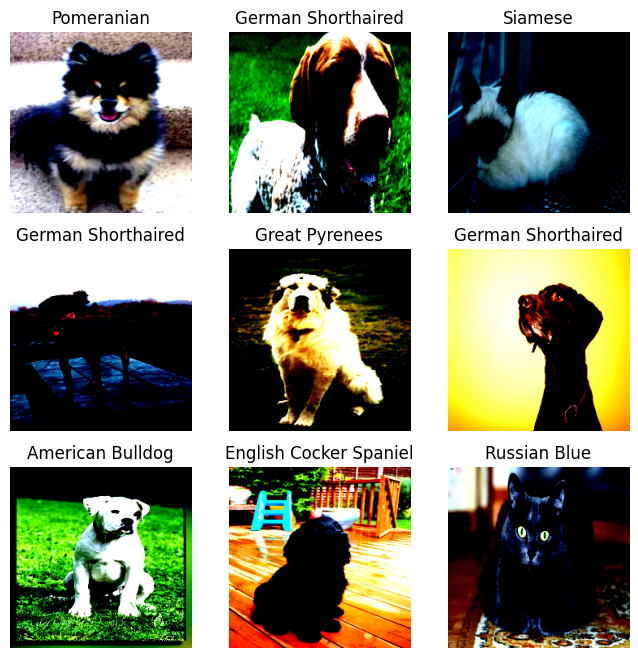

In [5]:
sample_image_dataset(complete_train_ds, labels=class_names)

4. Розділити обраний набір даних на дві вибірки: тренувальну та валідаційну, співвідношення розміру вибірок обрати на власний розсуд. Після чого розділити тренувальний набір на дві частини марковану (30%) та немарковану (70%);

In [6]:
batch_size = 256

train_ds, valid_ds = random_split(complete_train_ds, [0.931, 0.069], seeded_generator)
labeled_ds, unlabeled_ds = random_split(train_ds, [0.3, 0.7], seeded_generator)

train_loader = DataLoader(train_ds, batch_size=batch_size)
labeled_loader = DataLoader(labeled_ds, batch_size=batch_size)
unlabeled_loader = DataLoader(unlabeled_ds, batch_size=batch_size)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

print("Train dataset size: " + str(len(train_ds)))
print("Labeled dataset size: " + str(len(labeled_ds)))
print("Unlabeled dataset size: " + str(len(unlabeled_ds)))
print("Validation dataset size: " + str(len(valid_ds)))
print("Test dataset size: " + str(len(test_ds)))

Train dataset size: 3427
Labeled dataset size: 1029
Unlabeled dataset size: 2398
Validation dataset size: 253
Test dataset size: 3669


5. Завантажити та налаштувати нейронну мережу обраної архітектури;

In [7]:
supervised_student = Lab2Student(device, num_classes=num_classes, dropout=0.5)

loss_fun = CrossEntropyLoss()
optimizer = Adam(supervised_student.parameters())

supervised_student.eval()

Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

6. Провести навчання нейронної мережі на початковому (до розділу на маркований і немаркований) тренувальному наборі даних. Вибір гіперпараметрів на власний розсуд. Побудувати графіки точності та loss мережі під час навчання;


In [8]:
feedback = supervised_student.fit(
    num_epochs=10,
    train_loader=train_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun,
    optimizer=optimizer,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy of the network: 87.21109068627452 %
Loss of the network: 0.5635083213448524


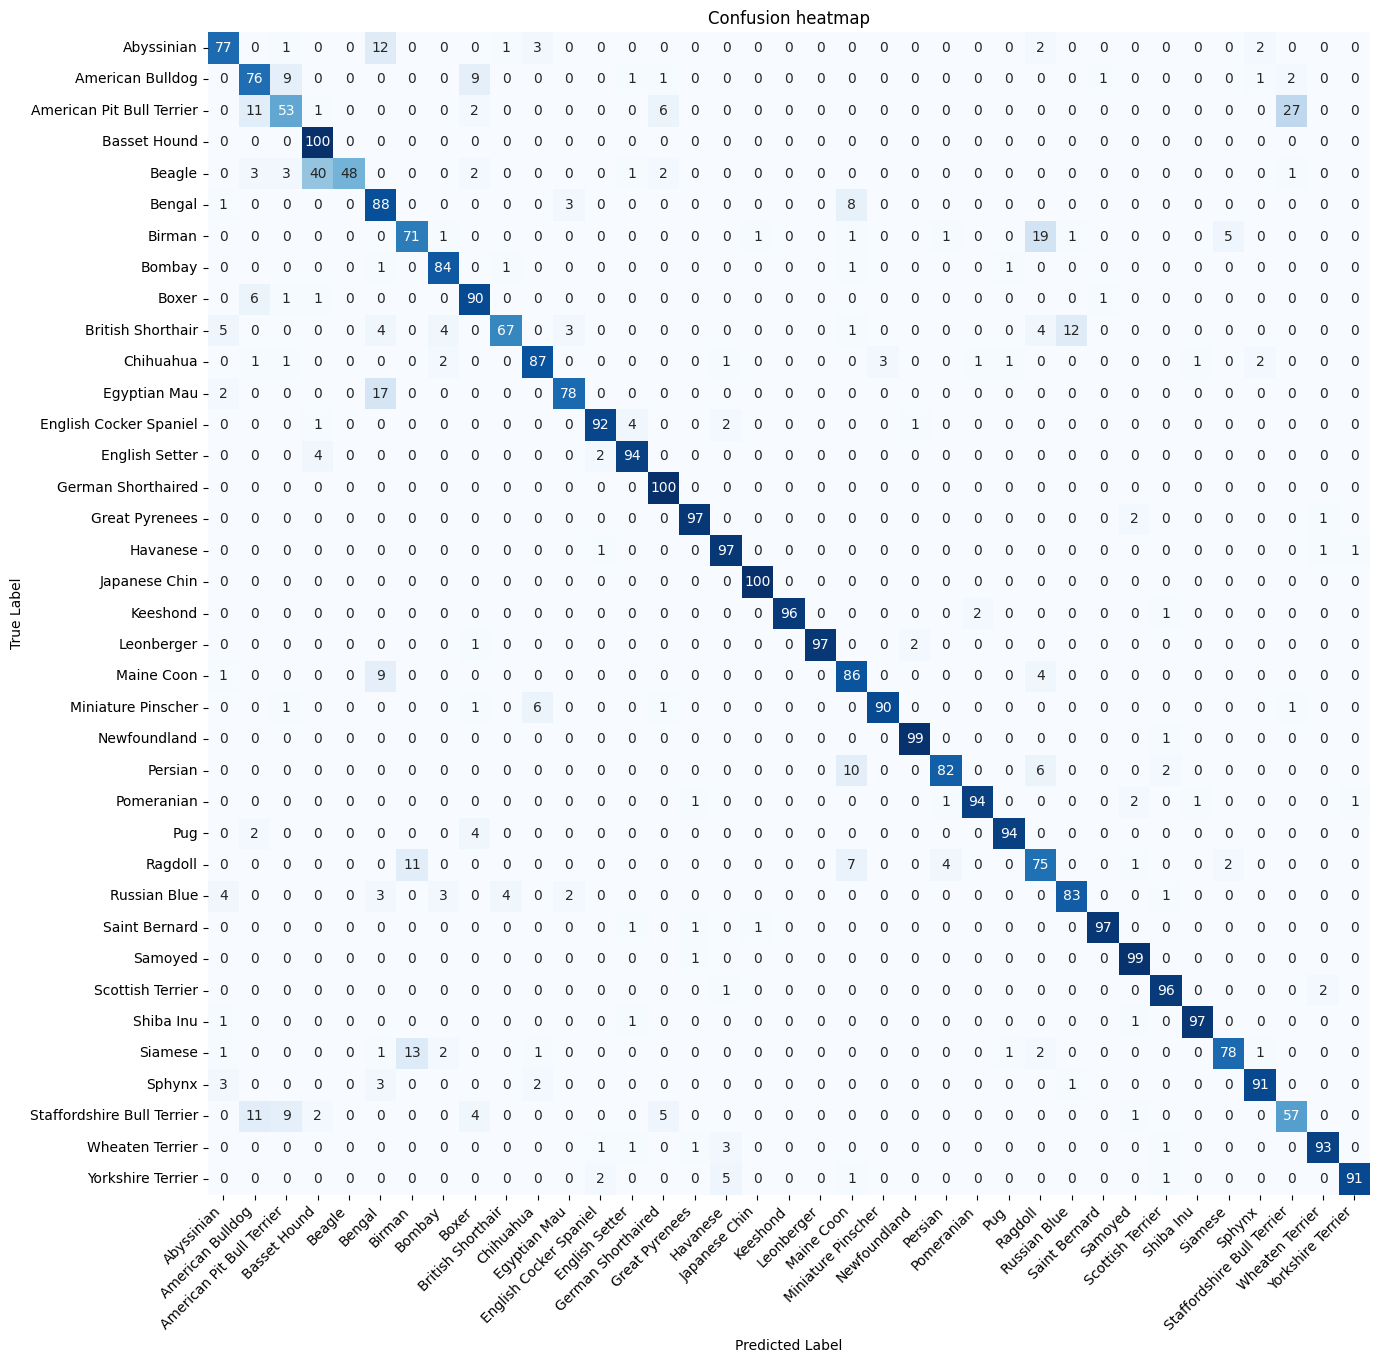

In [9]:
test_loss, test_accuracy, confusion = supervised_student.test(loss_fun, test_loader, record_class_stats=True)

print("Accuracy of the network: %s %%" % (test_accuracy * 100))
print("Loss of the network: %s" % test_loss)

plot_confusion_matrix_heatmap(confusion, labels=class_names)

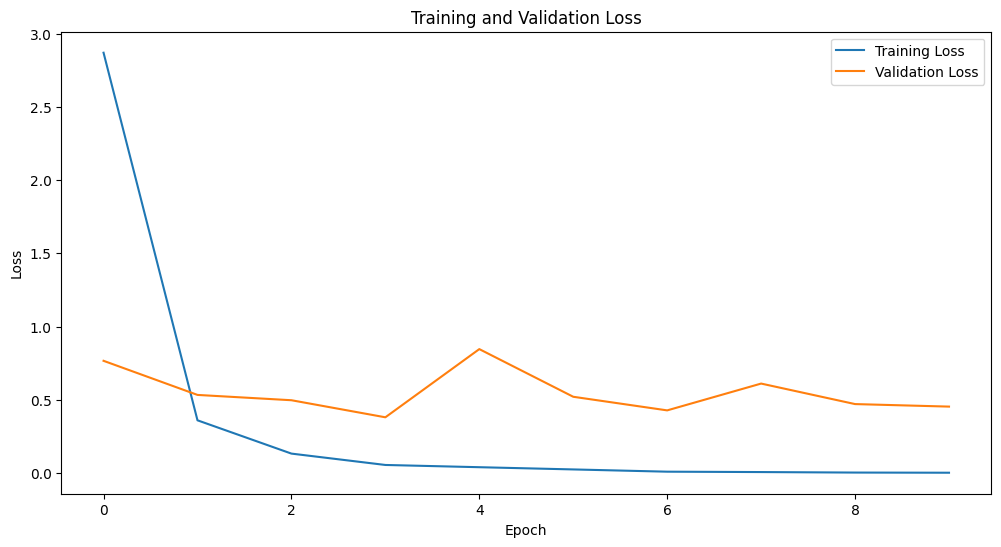

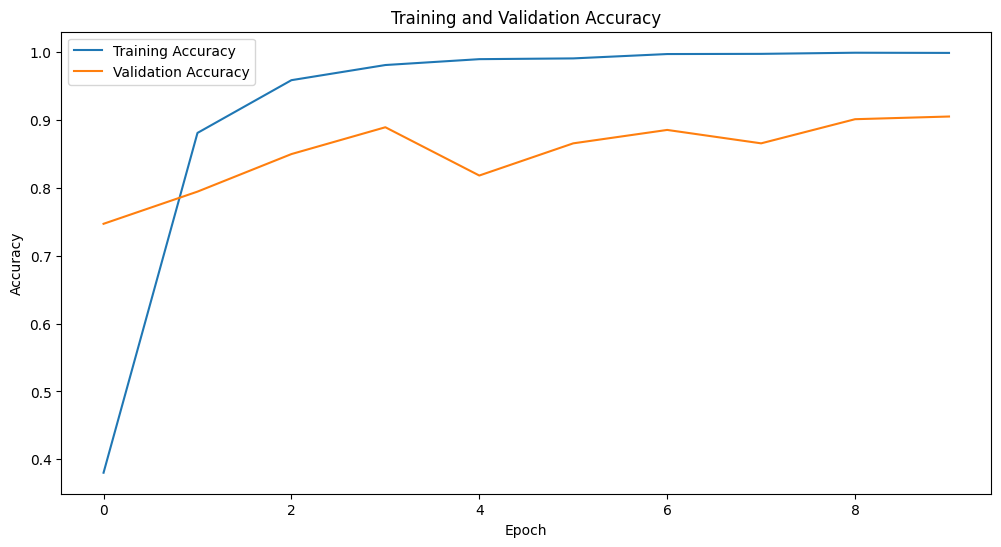

In [10]:
plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)

7. Зберегти ваги навченої нейронної мережі у файл.

In [11]:
supervised_student.persist(MODELS_FOLDER / "lab-2-supervised-student.pickle")

8. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці. Вибір гіперпараметрів на власний розсуд. Побудувати графік точності моделі;


In [12]:
teacher = Lab2Teacher(device, num_classes=num_classes, dropout=0.5)

loss_fun = CrossEntropyLoss()
optimizer = Adam(teacher.parameters())

teacher.eval()

Lab2Teacher(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [13]:
teacher_feedback = teacher.fit(
    num_epochs=10,
    train_loader=labeled_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun,
    optimizer=optimizer,
)

Overall progress:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Accuracy of the network: 78.5404411764706 %
Loss of the network: 0.7908406605323156


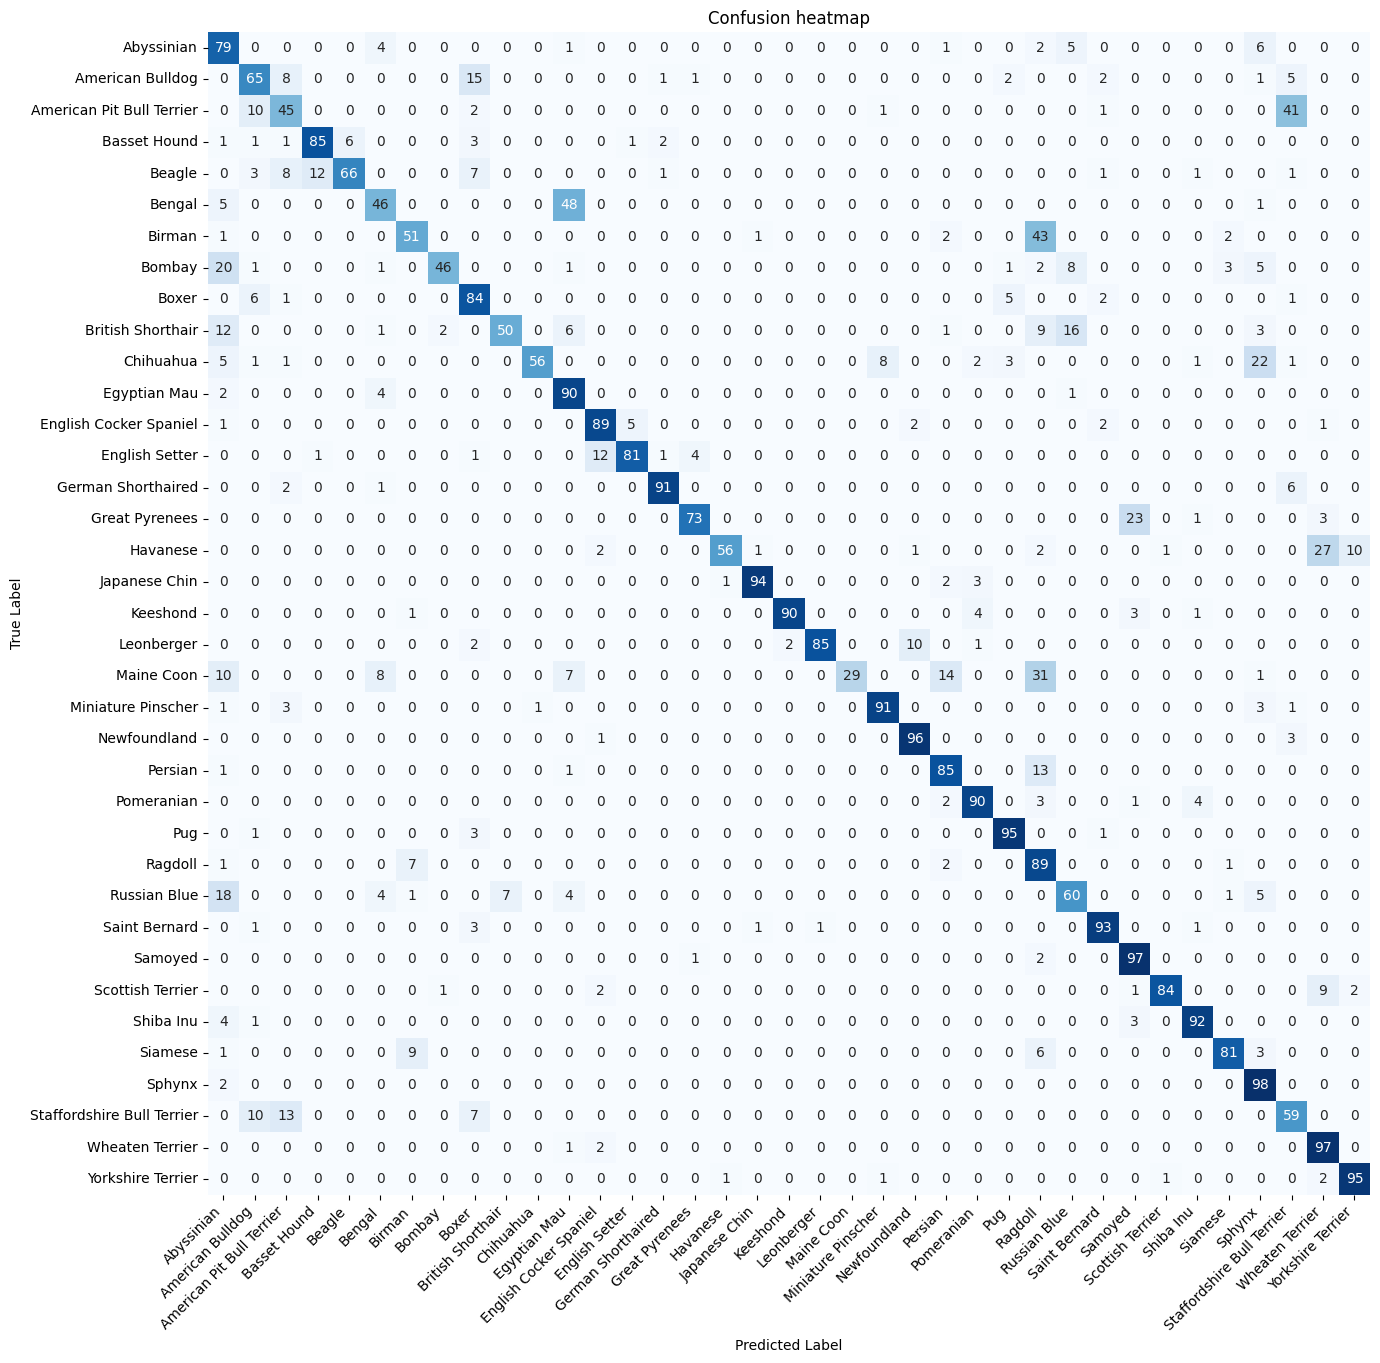

In [14]:
teacher_test_loss, teacher_test_accuracy, teacher_confusion = teacher.test(
    loss_fun, test_loader, record_class_stats=True
)

print("Accuracy of the network: %s %%" % (teacher_test_accuracy * 100))
print("Loss of the network: %s" % teacher_test_loss)

plot_confusion_matrix_heatmap(teacher_confusion, labels=class_names)

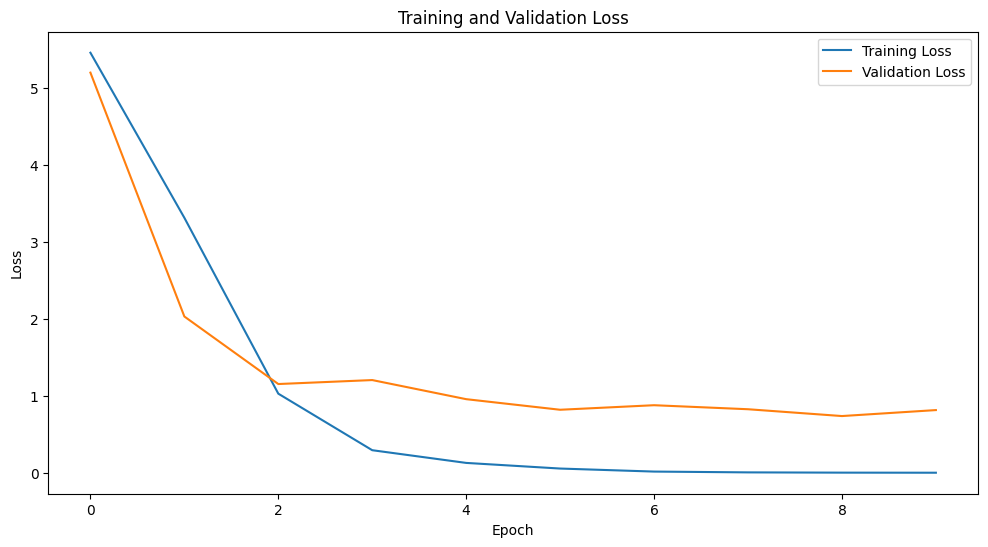

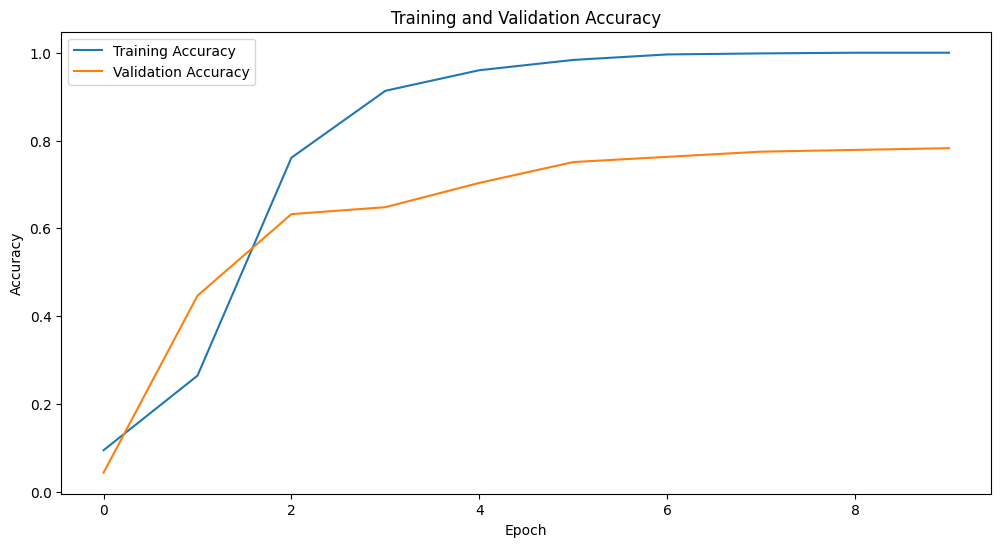

In [15]:
plot_loss_and_val_loss(
    teacher_feedback.train_loss_history, teacher_feedback.valid_loss_history
)
plot_loss_and_val_accuracy(
    teacher_feedback.train_accuracy_history, teacher_feedback.valid_accuracy_history
)

In [16]:
teacher.persist(MODELS_FOLDER / "lab-2-teacher.pickle")

In [17]:
augmentation_trans = v2.Compose(
    [v2.RandAugment()]
) 

semi_supervised_ds = SemiSupervisedDataset(
    unlabeled_ds, teacher.forward_loader(unlabeled_loader)
)
noisy_student_ds = TransformerDataset(
    ConcatDataset([labeled_ds, semi_supervised_ds]), augmentation_trans
)

noisy_student_loader = DataLoader(noisy_student_ds, batch_size=batch_size)

In [19]:
semi_supervised_student = Lab2Student(device, num_classes=num_classes, dropout=0.9)

loss_fun = CrossEntropyLoss()
optimizer = SGD(semi_supervised_student.parameters(), lr=0.01, momentum=0.9)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=1, min_lr=1e-6
)

semi_supervised_student.eval()

Lab2Student(
  (net): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [20]:
student_feedback = semi_supervised_student.fit(
    num_epochs=20,
    train_loader=noisy_student_loader,
    valid_loader=valid_loader,
    loss_fun=loss_fun,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler
)

Overall progress:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Accuracy of the network: 82.23927696078431 %
Loss of the network: 0.5043067641556263


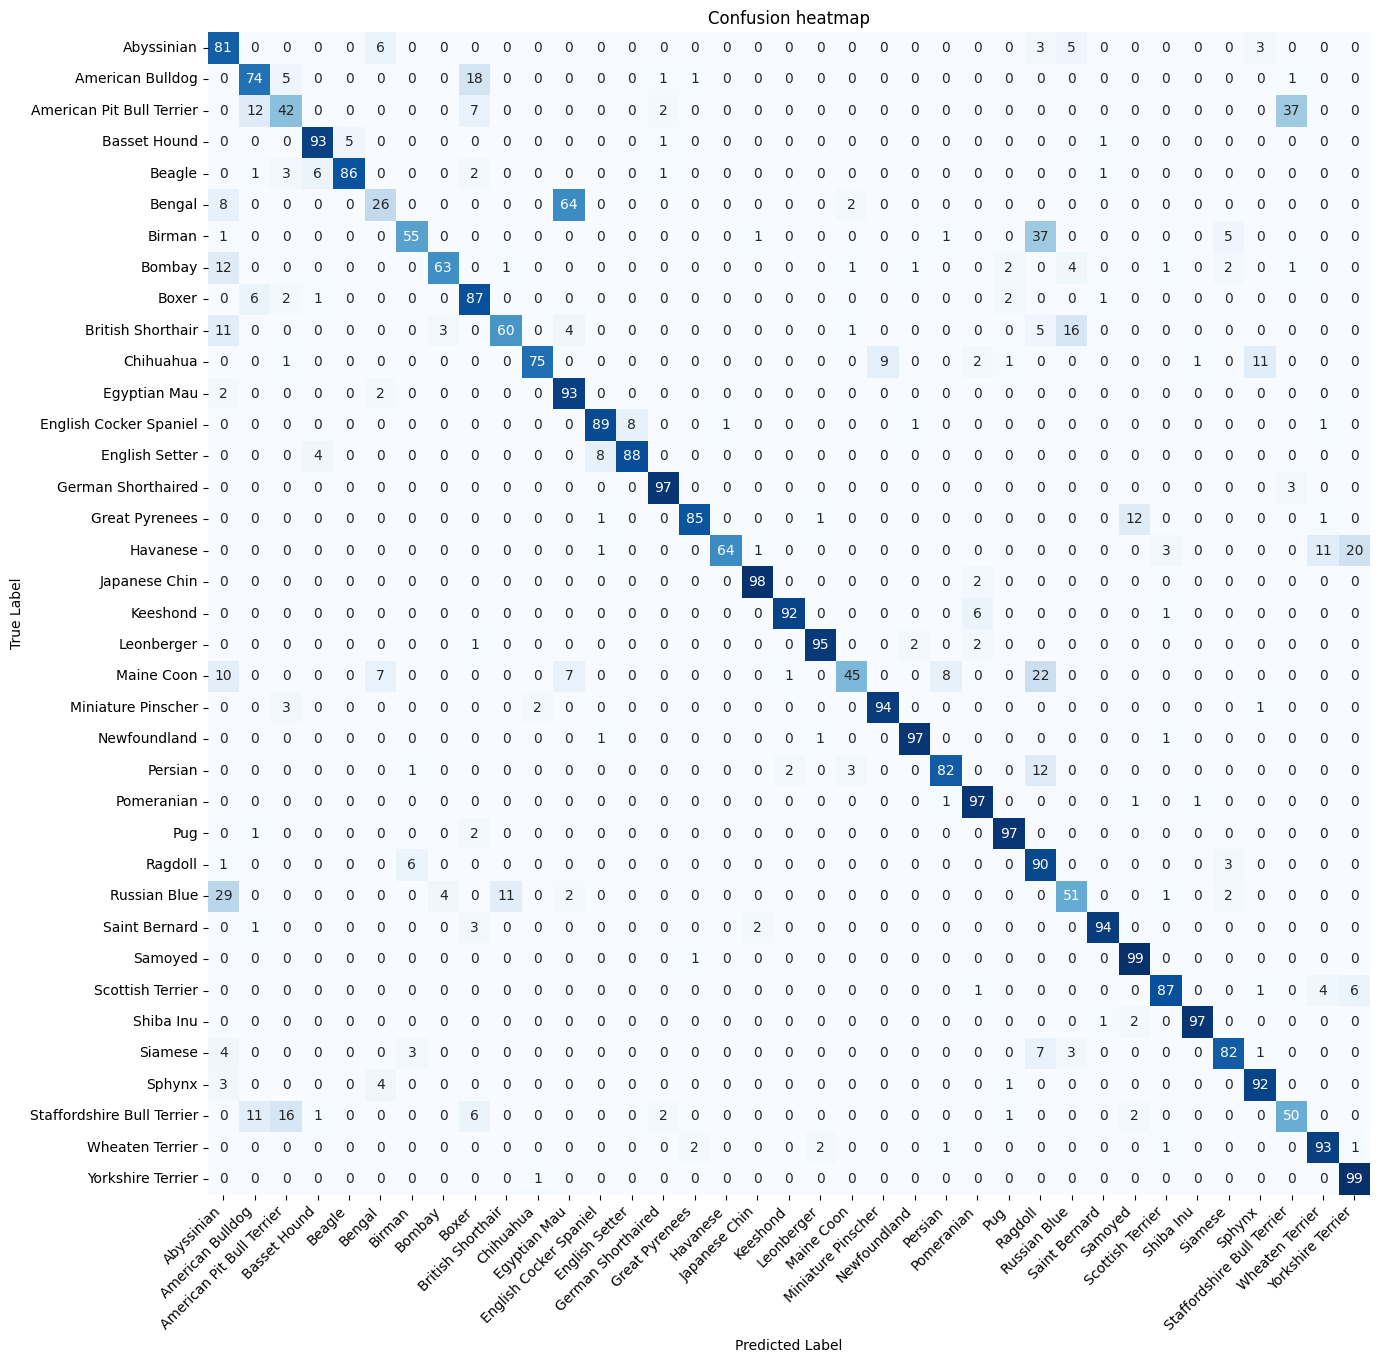

In [21]:
student_test_loss, student_test_accuracy, semi_supervised_confusion = (
    semi_supervised_student.test(loss_fun, test_loader, record_class_stats=True)
)

print("Accuracy of the network: %s %%" % (student_test_accuracy * 100))
print("Loss of the network: %s" % student_test_loss)

plot_confusion_matrix_heatmap(semi_supervised_confusion, labels=class_names)

9. Зберегти ваги навченої нейронної мережі у файл.

In [22]:
supervised_student.persist(MODELS_FOLDER / "lab-2-semi-supervised-student.pickle")

10. Побудувати графіки точності та loss мережі під час навчання.

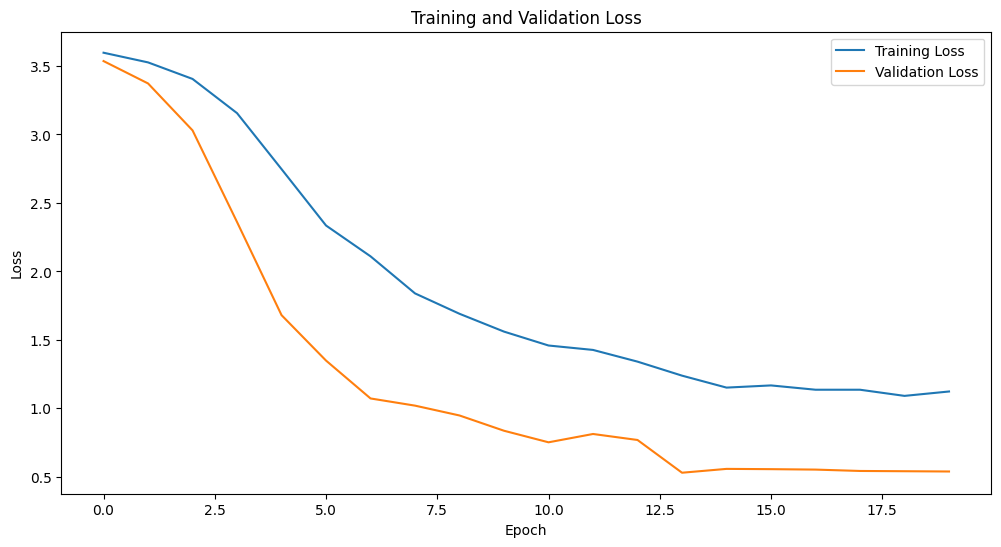

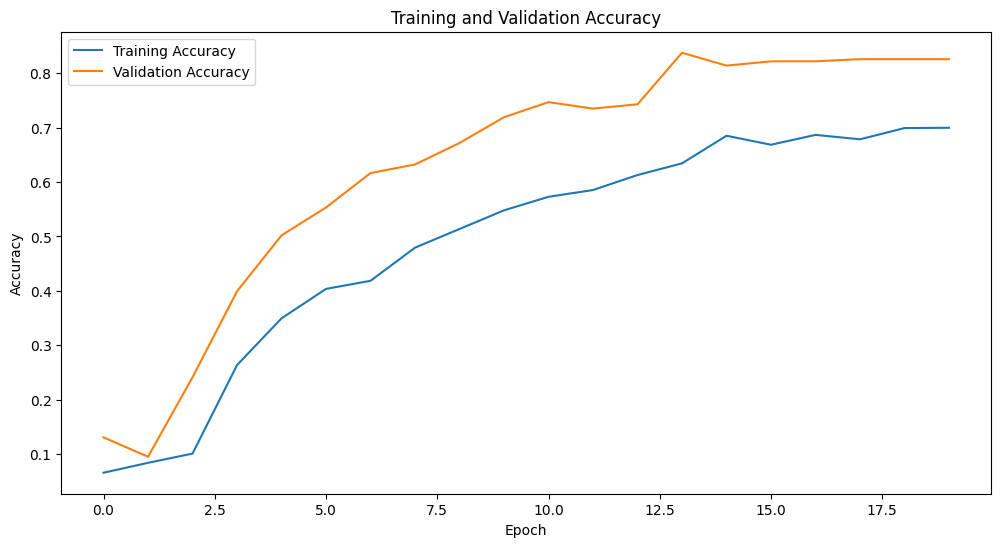

In [23]:
plot_loss_and_val_loss(
    student_feedback.train_loss_history, student_feedback.valid_loss_history
)
plot_loss_and_val_accuracy(
    student_feedback.train_accuracy_history, student_feedback.valid_accuracy_history
)

11. Зробити висновки, оформити звіт.